In [1]:
# Movie sentiment analysis
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.utils import plot_model

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

!wget https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/preprocess.py
import preprocess
from string import punctuation

--2022-10-15 04:12:33--  https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/preprocess.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1461 (1.4K) [text/plain]
Saving to: ‘preprocess.py’

preprocess.py       100%[===================>]   1.43K  --.-KB/s    in 0s      

2022-10-15 04:12:34 (22.1 MB/s) - ‘preprocess.py’ saved [1461/1461]



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  
  return train_df


def printInputOutput(index, train, train_text, train_label):
  print("Original input:", train['sentence'][index])
  print("Preprocessed text:", train_text[index])
  print("\nConverted to vector:", sequences[index])
  print("Sentiment label:", train_label[index])
  print("--------------------------")

  # Check the text to number conversion
  currentIndex = 0

  for word in train_text[index].split():
    if word in df_wordIndex.index:
      print(word, "-->", sequences[index][currentIndex])
      currentIndex += 1
    else:
      print(word)  

Download the [IMDB movie](https://www.imdb.com/) review dataset. The user comments and the corresponding ratings are the **labelled dataset** for the **supervised** machine learning

In [3]:
SHOW = 5
train = download_and_load_datasets()

print('Total training rows:', len(train))
train[:SHOW]

84125825/84125825 [==============================] - 8s 0us/step
Total training rows: 25000


,sentence,sentiment,polarity
0,Worst Bob Hope comedy ever(and that includes s...,1,0
1,Although Stardust seems to be a fantasy film w...,9,1
2,You gotta wonder how some flics ever get made....,2,0
3,"Not a film to be taken seriously, but a great ...",8,1
4,An old family story told to two young girls by...,7,1


In [4]:
# Preprocess the reviews which include remove symbols and stop words, to small cap, stem the words
train['preprocessed'] = train['sentence'].apply(preprocess.process)
train[:SHOW]

,sentence,sentiment,polarity,preprocessed
0,Worst Bob Hope comedy ever(and that includes s...,1,0,worst bob hope comedy ever includes heavy comp...
1,Although Stardust seems to be a fantasy film w...,9,1,although stardust seems fantasy film predictab...
2,You gotta wonder how some flics ever get made....,2,0,gotta wonder flics ever get made one decided s...
3,"Not a film to be taken seriously, but a great ...",8,1,film taken seriously great little film nonethe...
4,An old family story told to two young girls by...,7,1,old family story told two young girl grandfath...


In [5]:
# define input_x, input_y
train_text = train['preprocessed'].values
train_label = train['polarity'].values

In [6]:
index = 0
print('input_x:', train_text[index])
print('input_y:', train_label[index])

input_x: worst bob hope comedy ever includes heavy competition hope island sailor dream aloud bathtub geisha girl steering ship somebody certainly steered hope hackery cliff feature phyllis diller gina lollobrigida still work laugh excitement bing crosby really need
input_y: 0




*   Neural Network doesn't understand English word and only take **vector of numbers** for the input
*   Need to represent the input word sequence as vector of numbers for the Neural Network input
*   Use the word occurency frequency in the dataset as the word's indexed number (**ranking**) and use it to convert (encode) the words to numbers
*   The word_frequency is like a dictionary to map words to numbers
*   For simplicity, only consider the **top frequent 10,000 words** in the dataset (assume more frequent is more important)

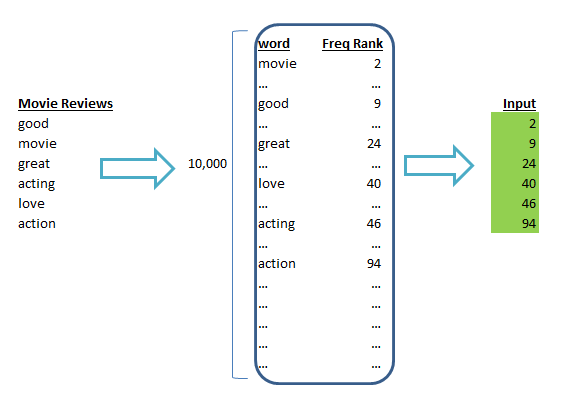

In [7]:
# For simplicity, only consider the top frequent 10,000 words in the dataset (assume more frequent is more important)
max_words = 10000 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_text)

word_index = tokenizer.word_index
print('Found %s unique tokens but will only consider the top frequent %s words' %(len(word_index), max_words))

# convert the words to a seqence of numbers (index by the top frequency of the words)
# The words in the text sequence will be indexed as a number by the word_index
sequences = tokenizer.texts_to_sequences(train_text)

# show the word_index
df_wordIndex = pd.DataFrame.from_dict(word_index, orient='index', columns=['number'])[:max_words]
df_wordIndex

Found 66401 unique tokens but will only consider the top frequent 10000 words


,number
br,1
movie,2
wa,3
film,4
one,5
...,...
intentioned,9996
tristan,9997
devos,9998
graceful,9999


In [8]:
index = 0
printInputOutput(index, train, train_text, train_label)

Original input: Worst Bob Hope comedy ever(and that includes some heavy competition). Hope, on an island with sailors, dreams aloud of being in a bathtub with a geisha girl "steering his ship". Somebody certainly steered this Hope-hackery over the cliff, as it features Phyllis Diller and Gina Lollobrigida and still can't work up any laughs or excitement. Where's Bing Crosby when you really need him?
Preprocessed text: worst bob hope comedy ever includes heavy competition hope island sailor dream aloud bathtub geisha girl steering ship somebody certainly steered hope hackery cliff feature phyllis diller gina lollobrigida still work laugh excitement bing crosby really need

Converted to vector: [149, 1735, 265, 93, 51, 1486, 996, 3086, 265, 877, 4266, 440, 8761, 5871, 81, 1163, 1590, 327, 265, 3192, 335, 8581, 4918, 56, 57, 221, 2050, 7435, 5571, 17, 155]
Sentiment label: 0
--------------------------
worst --> 149
bob --> 1735
hope --> 265
comedy --> 93
ever --> 51
includes --> 1486
heav

In [9]:
# We will cut reviews after maxlen words because neural network input is fixed size vector
maxlen = 200 
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(train_label)

print('Shape of data tensor', data.shape)
print('Shape of labels tensor', labels.shape)

Shape of data tensor (25000, 200)
Shape of labels tensor (25000,)


In [10]:
# Now the training X, Y is the acceptable format by Neural Network
# Input X is a vectors and Y is the corresponding labels (i.e. the sentiment)
index = 0
print(data[index])
print("\n lable:", labels[index])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  149 1735  265   93   51 1486  996 3086  265  877 4266  440 8761
 5871   81 1163 1590  327  265 3192  335 8581 4918   56   57  221 2050
 7435 

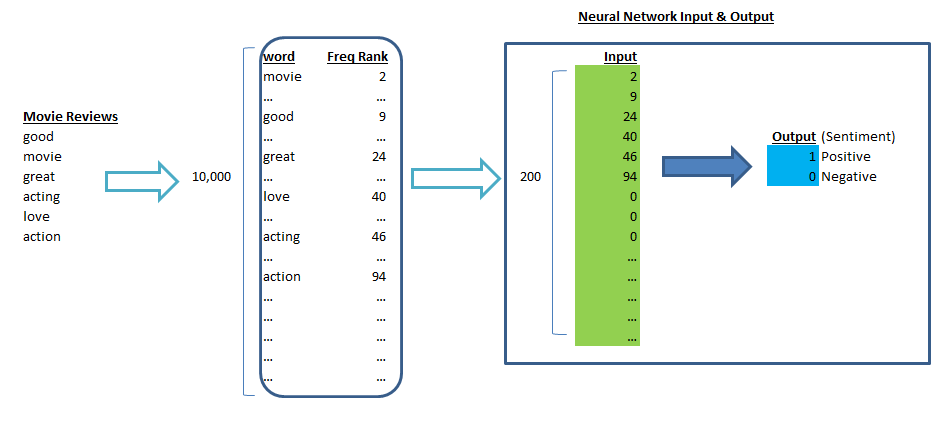

In [11]:
training_samples = 16000  
validation_samples = 4000  
test_samples = 5000

# Split the data into a training set and a validation set
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x_test = data[training_samples + validation_samples:]
y_test = labels[training_samples + validation_samples:]

test_text = train_text[training_samples + validation_samples:]
test_label = train_label[training_samples + validation_samples:]

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (16000, 200)
y_train shape: (16000,)
x_val shape: (4000, 200)
y_val shape: (4000,)
x_test shape: (5000, 200)
y_test shape: (5000,)


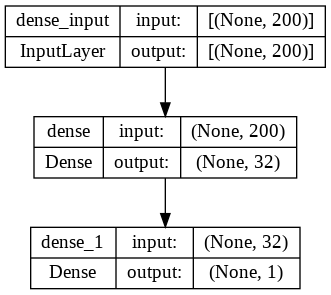

In [12]:
# Use the one hidden Dense layer connection which is similar to the MNIST (Digit) recognition
model = Sequential()

model.add(Dense(32, activation='relu', input_shape=(maxlen,)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

plot_model(model, show_shapes=True, show_layer_names=True)

# [9,2,...,200] --dense--> [1,2,.....,32] --dense_output--> 0 or 1

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                6432      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
500/500 [==============================] - 4s 3ms/step - loss: 136.3071 - accuracy: 0.4988 - val_loss: 2.3888 - val_accuracy: 0.5030
Epoch 2/10
500/500 [==============================] - 2s 3ms/step - loss: 1.3156 - accuracy: 0.5089 - val_loss: 0.8512 - val_accuracy: 0.4955
Epoch 3/10
500/500 [==============================] - 2s 4ms/step - loss: 0.8200 - accuracy: 0.5064 - val_loss: 0.7796 - val_accuracy: 0.4963
Epoch 4/10
500/500 [==============================] - 2s 4ms/step - loss: 0.7618 - accuracy: 0.5078 - val_loss: 0.7539 - val_accuracy: 0.4965
Epoch 5/10
500/500 [==============================] - 2s 3ms/step - loss: 0.7338 - accuracy: 0.5093 - val_loss: 0.7560 - val_accuracy: 0.4960
Epoch 6/10
500/500 [==============================] - 2s 3ms/step - loss: 0.7249 - accuracy: 0.5107 - val_loss: 0.7820 - val_accuracy: 0.4980
Epoch 7/10
500/500 [==============================] - 1s 3ms/step - loss: 0.7155 - accuracy: 0.5099 - val_loss: 0.7871 - val_accuracy: 0.4967
Epoc

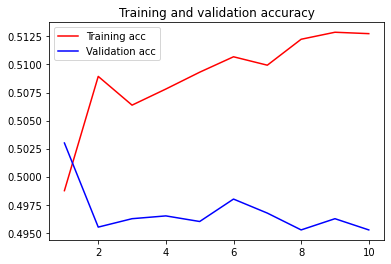

In [14]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

# Plot the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [15]:
# The accuracy is not high. As human langauge is complex and the input contain 200 numbers, try with more neurons and layers?

*   As usual, the neural network will **learn the input/output associations** (i.e. map the sentence in sequence numberrs to the corresponding sentiment label)

*   However, in order to learning the associations (mapping) effectively, neural network needs to understand the text (which are now merely encoded as numbers by the frequency of appearance in the movies reviews) 

*   So the challenge is that the Neural Network has to learn 2 things (**input/output mapping and language understanding**) at the same time

*   Comparing to the image recognition, the pixel positions are naturally mapped to the vectors to represent the image spatial relationship.


In [16]:
# The key idea here is to use word2vec (a pretrained vector which understand the text to certain extends) 
# to solve the 2nd issue (text understanding) and helps the neural network to learn the input/output mappings.
# Also, the word2vec output is a vector and which is exactly the required format for Neural Network

from gensim.models import word2vec

reviews = [sent.split(' ') for sent in train['preprocessed']]
w2vModel = word2vec.Word2Vec(reviews, min_count=5, size=64, window=5)
w2v = w2vModel.wv

print("No.of words in the vocab:", len(w2v.vocab))

No.of words in the vocab: 25569


In [17]:
# w2v is a word represented by a vector of numbers
w2v['movie']

array([-1.9297298 ,  0.26510897, -1.5280428 , -0.7822159 , -0.15625143,
        0.4895106 ,  1.558302  , -0.06085854, -0.43086144,  0.02296423,
        1.4672669 ,  0.6889659 ,  2.581756  , -0.5507711 , -3.165172  ,
       -0.29457366, -0.13294894, -0.07955406, -0.391661  , -1.2655818 ,
        0.07613962, -2.2929916 ,  1.7846016 , -0.06487453, -1.6199816 ,
        0.81565654,  2.6487143 , -0.28805375,  0.9964592 , -0.61197114,
       -0.72873837,  0.42996657,  0.04262876,  0.4789726 ,  1.2349604 ,
       -0.99468315, -0.54061466,  1.7030869 , -0.05833667, -1.049893  ,
        2.016251  ,  0.41856605,  2.3935194 ,  1.088103  ,  0.19380333,
        0.87791806,  0.79034996,  1.0459725 , -0.9558535 , -1.1850156 ,
       -1.1275961 , -1.1811657 , -1.6815484 , -0.00730957,  0.14357299,
       -0.00768349,  0.31194925, -1.5735096 , -1.027628  ,  0.29395744,
       -1.2738276 , -0.3227304 , -0.26696506,  3.3976917 ], dtype=float32)

In [18]:
w2v.most_similar('movie')

[('film', 0.8496465086936951),
 ('flick', 0.7013645172119141),
 ('sequel', 0.6360251307487488),
 ('amazed', 0.6026262640953064),
 ('thats', 0.6019948124885559),
 ('anime', 0.5948226451873779),
 ('sure', 0.5922703742980957),
 ('honestly', 0.5844349265098572),
 ('nowadays', 0.578964114189148),
 ('opinion', 0.5783712267875671)]

* Build the **embedding matrix** from the word2vec that we will be able to add to the Neural Network as a layer called **Embedding layer** each 
* For each row, it contains the corresponding word2vec vector to the word freqency index which built during earlier tokenization step.
* Think of the Embedding layer as another dictionary to map each number (the word indexed by the word frequency) to a vector (word2vec)


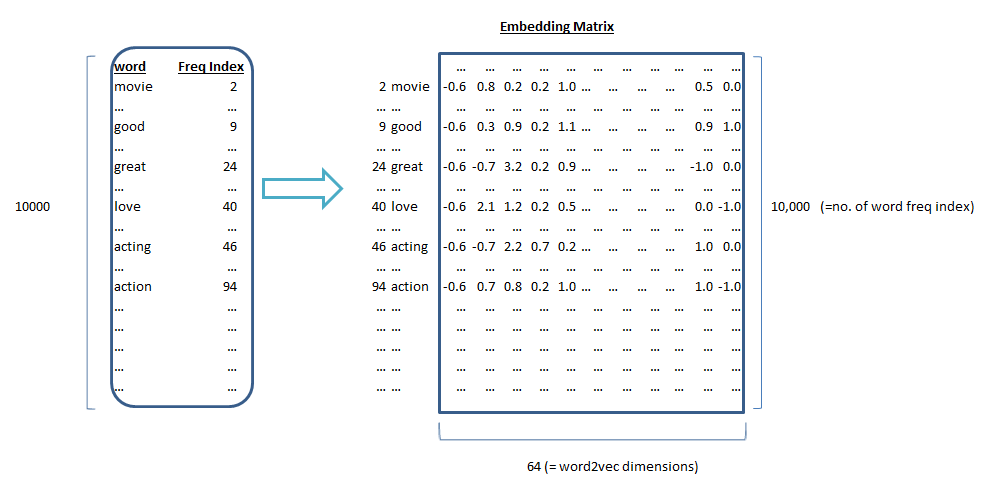

In [19]:
# Note that the index 0 is not supposed to stand for any word or token -- it's a placeholder.
# The Embedding layer a matrix of shape (max_words, embedding_dim), 

embedding_dim = w2v.vector_size
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  # Words not found in embedding index will be all-zeros.
  if word in w2v.vocab and i < max_words:
    embedding_matrix[i] = w2v[word]

print("embedding_matrix.shape:", embedding_matrix.shape)

embedding_matrix.shape: (10000, 64)


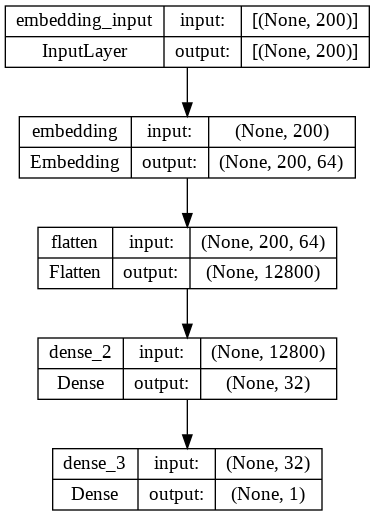

In [20]:
w2vModel = Sequential()

# Use w2v embedding layer to injects "pre-trained" language knowledge 
# to encode (represent) the input data more meaningfully
# It is a type of transfer learning 
w2vModel.add(Embedding(max_words, embedding_dim, input_length=maxlen))

# Then flatten the embedding output to a single vector for the hidden Dense layer 
# flatten the 200 sequence of 300-dim w2v vector into one single vector for dense layer
w2vModel.add(Flatten())
w2vModel.add(Dense(32, activation='relu'))
w2vModel.add(Dense(1, activation='sigmoid'))

plot_model(w2vModel, show_shapes=True, show_layer_names=True)

# [9,2,...,200] --w2v_embedding--> [[1,3,...,4], [7,5,...19],...] --flatten--> [1,3,...4,7,5,...19,...] --dense--> [1,2,.....,32] --dense_output--> 0 or 1

In [21]:
w2vModel.summary()

# Embedding layer = max_words * embedding_dim = 10,000 * 300 = 3,000,000
# Flatten = (input) maxlen * embedding_dim = 200 * 300 = 60,000
# dense = flatten_output * dense_output_neurons + bias = 60,000 * 32 + 32 = 1,920,032
# dense_1 = dense_output * dense_1_output + bias = 32 * 1 + 1 = 33

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                409632    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,049,665
Trainable params: 1,049,665
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Load the Embedding layer from the embedding_matrix and no need to train the parameters 

w2vModel.layers[0].set_weights([embedding_matrix])
w2vModel.layers[0].trainable = False
w2vModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                409632    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,049,665
Trainable params: 409,665
Non-trainable params: 640,000
_________________________________________________________________


Epoch 1/10
500/500 [==============================] - 2s 4ms/step - loss: 0.4909 - accuracy: 0.7664 - val_loss: 0.4442 - val_accuracy: 0.7883
Epoch 2/10
500/500 [==============================] - 2s 3ms/step - loss: 0.2821 - accuracy: 0.8800 - val_loss: 0.5020 - val_accuracy: 0.7890
Epoch 3/10
500/500 [==============================] - 2s 3ms/step - loss: 0.1388 - accuracy: 0.9476 - val_loss: 0.6509 - val_accuracy: 0.7795
Epoch 4/10
500/500 [==============================] - 2s 3ms/step - loss: 0.0562 - accuracy: 0.9804 - val_loss: 0.9956 - val_accuracy: 0.7735
Epoch 5/10
500/500 [==============================] - 2s 3ms/step - loss: 0.0224 - accuracy: 0.9928 - val_loss: 1.1026 - val_accuracy: 0.7735
Epoch 6/10
500/500 [==============================] - 2s 3ms/step - loss: 0.0105 - accuracy: 0.9964 - val_loss: 1.4340 - val_accuracy: 0.7655
Epoch 7/10
500/500 [==============================] - 2s 3ms/step - loss: 0.0049 - accuracy: 0.9982 - val_loss: 1.6773 - val_accuracy: 0.7705
Epoch 

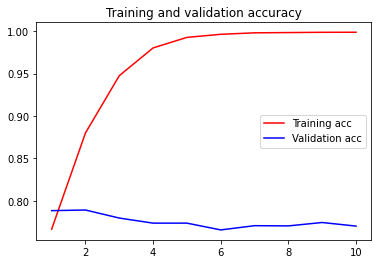

In [23]:
# compile the model after setting the Embedding layer to non-trainable
w2vModel.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = w2vModel.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

# Plot the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

## Try comparing to the dense connection with more neurons

In [24]:
# Do the prediction on the test set
score = w2vModel.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ans = w2vModel.predict(x_test)

Test loss: 2.1267731189727783
Test accuracy: 0.7771999835968018
157/157 [==============================] - 0s 2ms/step


In [25]:
# Predict individual movie review
p_index = 0

print("Movie Review:", test_text[p_index])
print("Truth Sentiment:", test_label[p_index])
print("Predicted Sentiment:", round(ans[p_index][0]))

Movie Review: spend money time pitiful piece film guise cinematography every third word devoted foul language real plot well cast old actor still giving dated performance past evolved career leaf lot said wa expecting something better award winning actor benicio del toro vision others may puertorricans irreversibly distorted trash maldeamores foul word given moment film may used emphasize given point view may even funny sad depending context see movie elsa fred example permeate plot movie total embarrassment wa absolutely nothing funny even cute film
Truth Sentiment: 0
Predicted Sentiment: 1


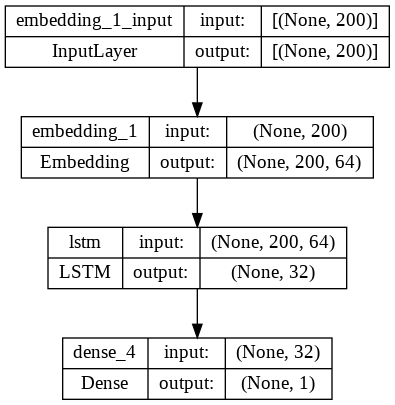

In [26]:
# Change the neural network architecture from dense layer to LSTM which is better for sequence 
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
from tensorflow.keras.layers import LSTM

lstm = Sequential()
lstm.add(Embedding(max_words, embedding_dim, input_length=maxlen))
# No need to flatten the vector (required for dense layer but not for LSTM)
lstm.add(LSTM(32))
lstm.add(Dense(1, activation='sigmoid'))

# Load the Embedding layer from the embedding_matrix and no need to train the parameters 
lstm.layers[0].set_weights([embedding_matrix])
lstm.layers[0].trainable = False

lstm.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

plot_model(lstm, show_shapes=True, show_layer_names=True)

# [good movie ....] --word_indexed_input--> [9,2,..,200] --w2v_embedding--> [[1,3,...,4], [7,5,...19],...] 
#   --LSTM--> [[1,3,...,4], [7,5,...19],...] --dense_output--> 0 or 1

In [27]:
lstm.summary()
# The lstm (LSTM) Param # = g * [h(h+i) + h]
# where g is number of gates and LSTM = 4
# h = no. of LSTM hidden neurons
# i = the dimension of input (feature)
# 4 * (32 (32 + 300) + 32) = 42624

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 652,449
Trainable params: 12,449
Non-trainable params: 640,000
_________________________________________________________________


Epoch 1/10
500/500 [==============================] - 10s 11ms/step - loss: 0.4498 - accuracy: 0.7976 - val_loss: 0.3954 - val_accuracy: 0.8263
Epoch 2/10
500/500 [==============================] - 5s 10ms/step - loss: 0.3720 - accuracy: 0.8401 - val_loss: 0.4041 - val_accuracy: 0.8270
Epoch 3/10
500/500 [==============================] - 5s 10ms/step - loss: 0.3427 - accuracy: 0.8566 - val_loss: 0.3844 - val_accuracy: 0.8245
Epoch 4/10
500/500 [==============================] - 5s 10ms/step - loss: 0.3231 - accuracy: 0.8649 - val_loss: 0.3803 - val_accuracy: 0.8403
Epoch 5/10
500/500 [==============================] - 5s 10ms/step - loss: 0.3044 - accuracy: 0.8735 - val_loss: 0.3408 - val_accuracy: 0.8580
Epoch 6/10
500/500 [==============================] - 5s 10ms/step - loss: 0.2886 - accuracy: 0.8813 - val_loss: 0.3202 - val_accuracy: 0.8612
Epoch 7/10
500/500 [==============================] - 5s 10ms/step - loss: 0.2769 - accuracy: 0.8875 - val_loss: 0.3498 - val_accuracy: 0.848

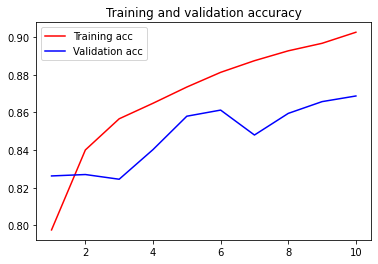

In [28]:
history = lstm.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

# Plot the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [29]:
# Suggested changes
# - Try with different max_words and maxlen in the data processing
# - Try with different training parameters for the word2vec (min_count, size, window)
# - When padding the text sequence to fixed size vector, removing some portion from the middle 
#       because usually the first and last sentence are more important as far as sentiment is concerned
# - Tune the neural network hyper-parameters
# - Train with other dataset such news sentiment dataset